In [20]:
import json
import os
import sys

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import ListedColormap
from omegaconf import OmegaConf
from torch.utils.data import DataLoader
from utils import data_process, helper

sys.append('../')

from get_mlp_mappings import ComputeMLPContributions
from image_vps_datasets import (single_image_cityscape_vps_dataset,
                                single_image_vipseg_dataset)
from model_all_analysis import ffn, lightning_model

In [21]:
def convert_tensor_annotations_to_numpy(tensor_annotations):
    annotations = []
    
    for tensor_anno in tensor_annotations:
        annotation = {}

        annotation['id'] = tensor_anno['id'].item()
        annotation['inst_id'] = tensor_anno['inst_id'].item()
        annotation['image_id'] = tensor_anno['image_id'][0] #.item()
        annotation['category_id'] = tensor_anno['category_id'].item()
        annotation['area'] = tensor_anno['area'].item()
        annotation['iscrowd'] = tensor_anno['iscrowd'].item()
        annotation['isthing'] = tensor_anno['isthing'].item()

        # Convert 'bbox' back to regular format
        bbox = [bbox_tensor.item() for bbox_tensor in tensor_anno['bbox']]
        annotation['bbox'] = bbox

        annotation['binary_mask'] = tensor_anno['binary_mask'].numpy()
        
        annotations.append(annotation)

    return annotations

def add_other_annotation(annotations):

    # Create a mask that will indicate whether a location contains at least one instance
    object_region_mask = None
    for ann in annotations:
        binary_mask = ann['binary_mask'].squeeze()
        if object_region_mask is None:
            # If the object_region_mask is None, initialize it to current binary_mask otherwise aggregate it
            object_region_mask = binary_mask.copy()
        else:
            object_region_mask += binary_mask

    # Binarize
    object_region_mask = object_region_mask != 0
    
    # Create an annotation denoting "other" for regions that have no objects
    annotations.append({
        "id": -1,
        "inst_id": -1,
        "bbox": compute_bbox(object_region_mask),
        "area": object_region_mask.sum(),
        "binary_mask": object_region_mask,
        'iscrowd': 0,
        'isthing': 0,
        'category_id': -1,
        'image_id': annotations[0]['image_id']
    })
    return annotations

def plot_image_with_instances(image, annotations, categories_dict, title=None):
    plt.rcParams["figure.figsize"] = 15, 10
    fig, ax = plt.subplots()

    # Plot the image
    ax.imshow(image)

    for anno in annotations:
        # Skip plotting "other" regions (regions without objects)
        if anno["category_id"] == -1:
            continue
        # Draw bbox
        x, y, w, h = anno["bbox"]

        cat_color = np.array(categories_dict[int(anno["category_id"])]['color']) / 255
        rectangle = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=cat_color, facecolor='none')
        ax.add_patch(rectangle)

        if 'binary_mask' in anno.keys():
            binary_mask = anno["binary_mask"].squeeze(0)
        else:
            raise ValueError("No binary mask found in annotation")
        # Create a mask where the binary mask is not zero
        mask = binary_mask != 0

        # Create rgba mask
        cmap = ListedColormap(cat_color)
        colored_mask = cmap(binary_mask.astype(float) / 1.0)

        # Create a mask where the binary mask is not zero
        mask = binary_mask != 0

        # Set the alpha channel to 0 for regions where the binary mask is zero
        colored_mask[:, :, 3] = mask.astype(float)
        
        # Display the colored mask over the image
        ax.imshow(colored_mask, alpha=0.5)

    if title is not None:
        plt.title(title)
    plt.show()
    
def compute_bbox(binary_mask):
    (rows, cols) = np.where(binary_mask > 0)
    x_min, x_max, y_min, y_max = min(cols), max(cols), min(rows), max(rows)
    # Create the bbox in COCO format [x, y, width, height]
    width = x_max - x_min + 1
    height = y_max - y_min + 1
    bbox = [x_min, y_min, width, height]
    return bbox

In [22]:
def load_cfg(model_ckpt_dir, dataset_name, vidname):
    
    if dataset_name == "cityscapes":
        # Add cityscapes VPS paths
        # vidname = "0005"
        exp_config_path = os.path.join(model_ckpt_dir, 'exp_config.yaml')
        
        cfg = OmegaConf.load(exp_config_path)
        
        cfg.data.cityscapes_vps_root = "../data/cityscapes_vps"
        cfg.data.split = "val"
        cfg.data.panoptic_video_mask_dir = os.path.join(cfg.data.cityscapes_vps_root, cfg.data.split, "panoptic_video")
        cfg.data.panoptic_inst_mask_dir = os.path.join(cfg.data.cityscapes_vps_root, cfg.data.split, "panoptic_inst")
        
        cfg.data.vidname = vidname
        # We will work with the first annotated frame in the given video
        cfg.data.frame_num_in_video = 0
        
        cfg.data.data_path = os.path.join(cfg.data.cityscapes_vps_root, cfg.data.split, "img_all")
        cfg.data.anno_path = '../data/cityscapes_vps/panoptic_gt_val_city_vps.json'
        
        with open(cfg.data.anno_path, 'r') as f:
            panoptic_gt_val_city_vps = json.load(f)
                    
        panoptic_categories = panoptic_gt_val_city_vps['categories']
        # panoptic_images = panoptic_gt_val_city_vps['images']
        # panoptic_annotations = panoptic_gt_val_city_vps['annotations']    
        
        categories = panoptic_categories
        categories.append(
            {'id': -1, 'name': 'other', 'supercategory': '', 'color':None}
        )
        categories_dict = {el['id']: el for el in categories}

    elif dataset_name == "vipseg":
        # vidname = "26_cblDl5vCZnw" #14_TzgdlZ2CZ3g, 20_o-wWIdQ1H98, 
        exp_config_path = os.path.join(model_ckpt_dir, 'exp_config.yaml')
        
        
        cfg = OmegaConf.load(exp_config_path)
        
        cfg.data.VIPSeg_720P_root = '../data/VIPSeg-Dataset/VIPSeg/VIPSeg_720P'
        cfg.data.panomasks_dir = os.path.join(cfg.data.VIPSeg_720P_root, "panomasks")
        cfg.data.panomasksRGB_dir = os.path.join(cfg.data.VIPSeg_720P_root, "panomasksRGB")
        
        cfg.data.vidname = vidname
        # We will work with the first annotated frame in the given video
        cfg.data.frame_num_in_video = 0
        
        cfg.data.data_path = data_path = os.path.join(cfg.data.VIPSeg_720P_root, "images")
        cfg.data.anno_path = '../data/VIPSeg-Dataset/VIPSeg/VIPSeg_720P/panoptic_gt_VIPSeg.json'
        
        # Crop for VIPSeg to match NeRV
        cfg.data.crop=[640,1280]
        
        with open(cfg.data.anno_path, 'r') as f:
            panoptic_gt_VIPSeg = json.load(f)
                    
        panoptic_categories = panoptic_gt_VIPSeg['categories']  
        
        categories = panoptic_categories
        categories.append(
            {'id': -1, 'name': 'other', 'supercategory': '', 'color':None}
        )
        categories_dict = {el['id']: el for el in categories}
        
    return cfg, categories_dict


def load_model(cfg):
    save_dir = cfg.logging.checkpoint.logdir
    ckpt_path = helper.find_ckpt(save_dir)
    print(f'Loading checkpoint from {ckpt_path}')

    checkpoint = torch.load(ckpt_path)

    # Load checkpoint into this wrapper model cause that is what is stored in disk :)
    model = lightning_model(cfg, ffn(cfg))
    model.load_state_dict(checkpoint['state_dict'])
    ffn_model = model.model
    
    return ffn_model.cuda()

def get_loader(cfg,dataset_name,val=False):
    # use the dataloader which returns image along with annotations
    if dataset_name == "cityscapes":
        img_dataset = single_image_cityscape_vps_dataset(cfg)
    else:
        img_dataset = single_image_vipseg_dataset(cfg)
    #create torch dataset for one image.
    loader = DataLoader(img_dataset, batch_size=1, shuffle = False ,num_workers=0)
    return loader


In [23]:
# Multiple videos
dataset_names = ['cityscapes', 'vipseg']
vidnames = {
    'cityscapes': ['0005', '0175'],
    'vipseg': ['12_n-ytHkMceew', '26_cblDl5vCZnw']
}

vid_data_folder_name = {
    "cityscapes": "Cityscapes_VPS_models",
    "vipseg": "VIPSeg_models"
}


cfg_dict = {}
dataloader_dict = {}
weights_dict = {}
ffn_models_dict = {}
categories_dicts = {}

In [ ]:
for dataset_name in dataset_names:
    weights_dict[dataset_name] = {}
    cfg_dict[dataset_name] = {}
    ffn_models_dict[dataset_name] = {}
    categories_dicts[dataset_name] = {}

    for vidname in vidnames[dataset_name]:
        vid_data_folder = vid_data_folder_name[dataset_name]
        weights_dict[dataset_name][vidname] = f'output/{vid_data_folder}/{vidname}/{vidname}_framenum_0_128_256'
        
        cfg, categories_dict = load_cfg(weights_dict[dataset_name][vidname], dataset_name, vidname)
        cfg_dict[dataset_name][vidname] = cfg
        categories_dicts[dataset_name][vidname] = categories_dict
        
        
        ffn_models_dict[dataset_name][vidname] = load_model(cfg)
        
for dataset_name in dataset_names:
    dataloader_dict[dataset_name] = {}
    
    for vidname in vidnames[dataset_name]:
        single_image_dataloader = get_loader(cfg_dict[dataset_name][vidname], dataset_name)
        
        dataloader_dict[dataset_name][vidname] = single_image_dataloader

In [25]:
def compute_inference_results(single_image_dataloader, ffn_model, cfg):
    with torch.no_grad():
        batch = next(iter(single_image_dataloader))

    data = batch['data'].cuda()
    N,C,H,W = data.shape
    annotations = convert_tensor_annotations_to_numpy(batch['annotations'])
    annotations = add_other_annotation(annotations)

    features = batch['features'].squeeze().cuda()
    features_shape = batch['features_shape'].squeeze().tolist()
    reshape = True

    proc = data_process.DataProcessor(cfg.data, device='cpu')
    x = batch['data']
    coords = proc.get_coordinates(data_shape=features_shape,patch_shape=cfg.data.patch_shape,\
                                    split=cfg.data.coord_split,normalize_range=cfg.data.coord_normalize_range)
    coords = coords.to(x).cuda()

    # Create a dictionary to store the intermediate decoder_results from each seeded model, over time.
    inference_results = {}
    kwargs = {}
    with torch.no_grad():
        out = ffn_model(coords, img=data)
        pred = out['predicted']
        intermediate_results = out["intermediate_results"]
        
        if reshape:
            # This reshapes the prediction into an image
            pred = proc.process_outputs(
                pred,input_img_shape=batch['data_shape'].squeeze().tolist(),\
                features_shape=features_shape,\
                patch_shape=cfg.data.patch_shape)

    inference_results = {
        "data": batch["data"],
        "pred": pred,
        "annotations": annotations,
        "img_hw": (H,W),
        "intermediate_results": intermediate_results
    }
    
    return inference_results

In [39]:
def plot_pixels_per_neuron(inference_results, ffn_model):
    gt_img = inference_results["data"][0]
    pred = inference_results["pred"]
    intermediate_results = inference_results["intermediate_results"]
    (H,W) = inference_results["img_hw"]

    # Get model contributions
    compute_contrib_obj = ComputeMLPContributions(
        ffn_model, intermediate_results, (H,W)
    )

    layer_1_output_contrib, layer_2_output_contrib, layer_3_output_contrib, _, _, _ = compute_contrib_obj.compute_all_layer_mappings()

    layer_1_contrib_abs = torch.abs(layer_1_output_contrib).flatten(1,2)
    layer_2_contrib_abs = torch.abs(layer_2_output_contrib).flatten(1,2)
    layer_3_contrib_abs = torch.abs(layer_3_output_contrib).flatten(1,2)
    
    # Sum contribs across neurons for each pixel
    layer_1_contribs_fraction = layer_1_contrib_abs / layer_1_contrib_abs.sum(dim=0)
    layer_2_contribs_fraction = layer_2_contrib_abs / layer_2_contrib_abs.sum(dim=0)
    layer_3_contribs_fraction = layer_3_contrib_abs / layer_3_contrib_abs.sum(dim=0)
    
    num_pixels_with_meaningful_contrib_dict = {}
    
    fig, axs = plt.subplots(1, 1, figsize=(20, 10)) # len(threshold
        
    # size - num_kernels
    layer_1_num_pixels_with_meaningful_contrib = (layer_1_contribs_fraction > (1 / layer_1_output_contrib.size(0))).sum(dim=1)
    layer_2_num_pixels_with_meaningful_contrib = (layer_2_contribs_fraction > (1 / layer_2_output_contrib.size(0))).sum(dim=1)
    layer_3_num_pixels_with_meaningful_contrib = (layer_3_contribs_fraction > (1 / layer_3_output_contrib.size(0))).sum(dim=1)
    
    
    # Sort
    layer_1_num_pixels_with_meaningful_contrib, _ = torch.sort(layer_1_num_pixels_with_meaningful_contrib)
    layer_2_num_pixels_with_meaningful_contrib, _ = torch.sort(layer_2_num_pixels_with_meaningful_contrib)
    layer_3_num_pixels_with_meaningful_contrib, _ = torch.sort(layer_3_num_pixels_with_meaningful_contrib)
    
    axs.plot(layer_3_num_pixels_with_meaningful_contrib, label="Layer 3")
    axs.plot(layer_2_num_pixels_with_meaningful_contrib, label="Layer 2")
    axs.plot(layer_1_num_pixels_with_meaningful_contrib, label="Layer 1")
    
    num_pixels_with_meaningful_contrib_dict = {
        "layer_1": layer_1_num_pixels_with_meaningful_contrib,
        "layer_2": layer_2_num_pixels_with_meaningful_contrib,
        "layer_3": layer_3_num_pixels_with_meaningful_contrib
    }
    
    plt.legend()
    axs.set_title(f"Threshold 1/num_neurons")

    plt.show()
    
    return num_pixels_with_meaningful_contrib_dict

# Neurons per pixel

In [9]:
def compute_contrib_thresh_using_auc(abs_contrib_map , target_area=0.05):
    total_sum = abs_contrib_map.sum()

    cutoff_contrib_sum = total_sum * (1 - target_area)

    # Flatten the tensor and calculate cumulative sum
    sorted_contributions = abs_contrib_map.flatten()
    sorted_indices = torch.argsort(sorted_contributions, descending=True)
    cum_sum = torch.cumsum(sorted_contributions[sorted_indices], dim=0)

    # Find the index where cumulative sum exceeds the cutoff
    idx = torch.nonzero(cum_sum >= cutoff_contrib_sum, as_tuple=False)[0, 0].item()
    chosen_thresh = sorted_contributions[sorted_indices][idx]
    
    # print(chosen_thresh)
    return chosen_thresh

In [10]:
def plot_neurons_per_pixel_heatmap(inference_results, ffn_model):
    gt_img = inference_results["data"][0]
    pred = inference_results["pred"]
    intermediate_results = inference_results["intermediate_results"]
    (H,W) = inference_results["img_hw"]

    # Get model contributions
    compute_contrib_obj = ComputeMLPContributions(
        ffn_model, intermediate_results, (H,W)
    )

    layer_1_output_contrib, layer_2_output_contrib, layer_3_output_contrib, _, _, _ = compute_contrib_obj.compute_all_layer_mappings()

    layer_1_contrib_abs = torch.abs(layer_1_output_contrib)
    layer_2_contrib_abs = torch.abs(layer_2_output_contrib)
    layer_3_contrib_abs = torch.abs(layer_3_output_contrib)
        
    target_areas = [0.1, 0.5]
    
    num_kernels_with_meaningful_contrib = {}
        
    # Separate subplots for different thresholds
    for target_area in target_areas:
        
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        
        # Compute layerwise threshold contributions
        layer_1_thresh = compute_contrib_thresh_using_auc(abs_contrib_map = layer_1_contrib_abs, target_area = target_area)
        layer_2_thresh = compute_contrib_thresh_using_auc(abs_contrib_map = layer_2_contrib_abs, target_area = target_area) 
        layer_3_thresh = compute_contrib_thresh_using_auc(abs_contrib_map = layer_3_contrib_abs, target_area = target_area) 
        
        # size - num_kernels
        # Get as Percentage of total kernels
        layer_1_num_kernels_with_meaningful_contrib = (layer_1_contrib_abs > layer_1_thresh).sum(dim=0) / layer_1_contrib_abs.size(0)
        layer_2_num_kernels_with_meaningful_contrib = (layer_2_contrib_abs > layer_2_thresh).sum(dim=0) / layer_2_contrib_abs.size(0)
        layer_3_num_kernels_with_meaningful_contrib = (layer_2_contrib_abs > layer_3_thresh).sum(dim=0) / layer_3_contrib_abs.size(0)
        
        axs[0].imshow(gt_img.permute(1,2,0).cpu().numpy())
        im1 = axs[3].imshow(layer_3_num_kernels_with_meaningful_contrib, cmap='magma')
        im2 = axs[2].imshow(layer_2_num_kernels_with_meaningful_contrib, cmap='magma')
        im3 = axs[1].imshow(layer_1_num_kernels_with_meaningful_contrib, cmap='magma')
        
        axs[0].set_title("Ground Truth Image")
        axs[1].set_title(f"Layer 3 Heatmap - layer_1_thresh={layer_1_thresh:.4f}")
        axs[2].set_title(f"Layer 2 Heatmap - layer_2_thresh={layer_2_thresh:.4f}")
        axs[3].set_title(f"Layer 1 Heatmap - layer_3_thresh={layer_3_thresh:.4f}")
        

        for ax in axs:
            ax.axis('off')
            
        # fig.suptitle(f"Neurons per Pixel Heatmap (Meaningful Contribution above Threshold {thresh})", y=0.65)
        fig.suptitle(f"Neurons per Pixel Heatmap (Contributions above Target Area Under Sorted Curve {target_area*100}%)", y=0.7)
        
        plt.show()
        
        num_kernels_with_meaningful_contrib[target_area] = {
            "layer_1": layer_1_num_kernels_with_meaningful_contrib,
            "layer_2": layer_2_num_kernels_with_meaningful_contrib,
            "layer_3": layer_3_num_kernels_with_meaningful_contrib
        }
        
    return num_kernels_with_meaningful_contrib

# Try different images

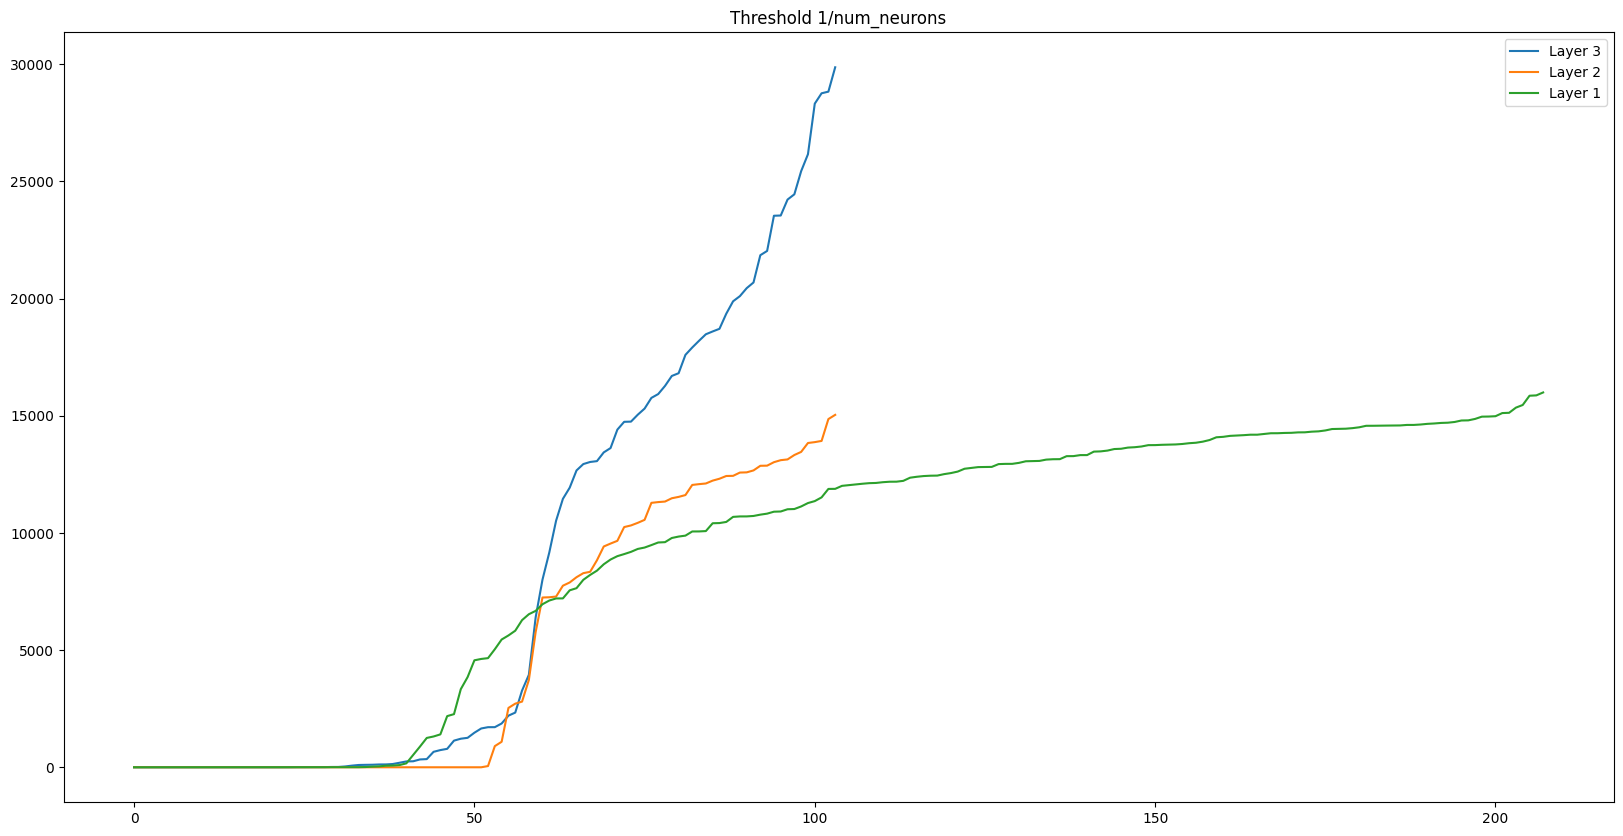

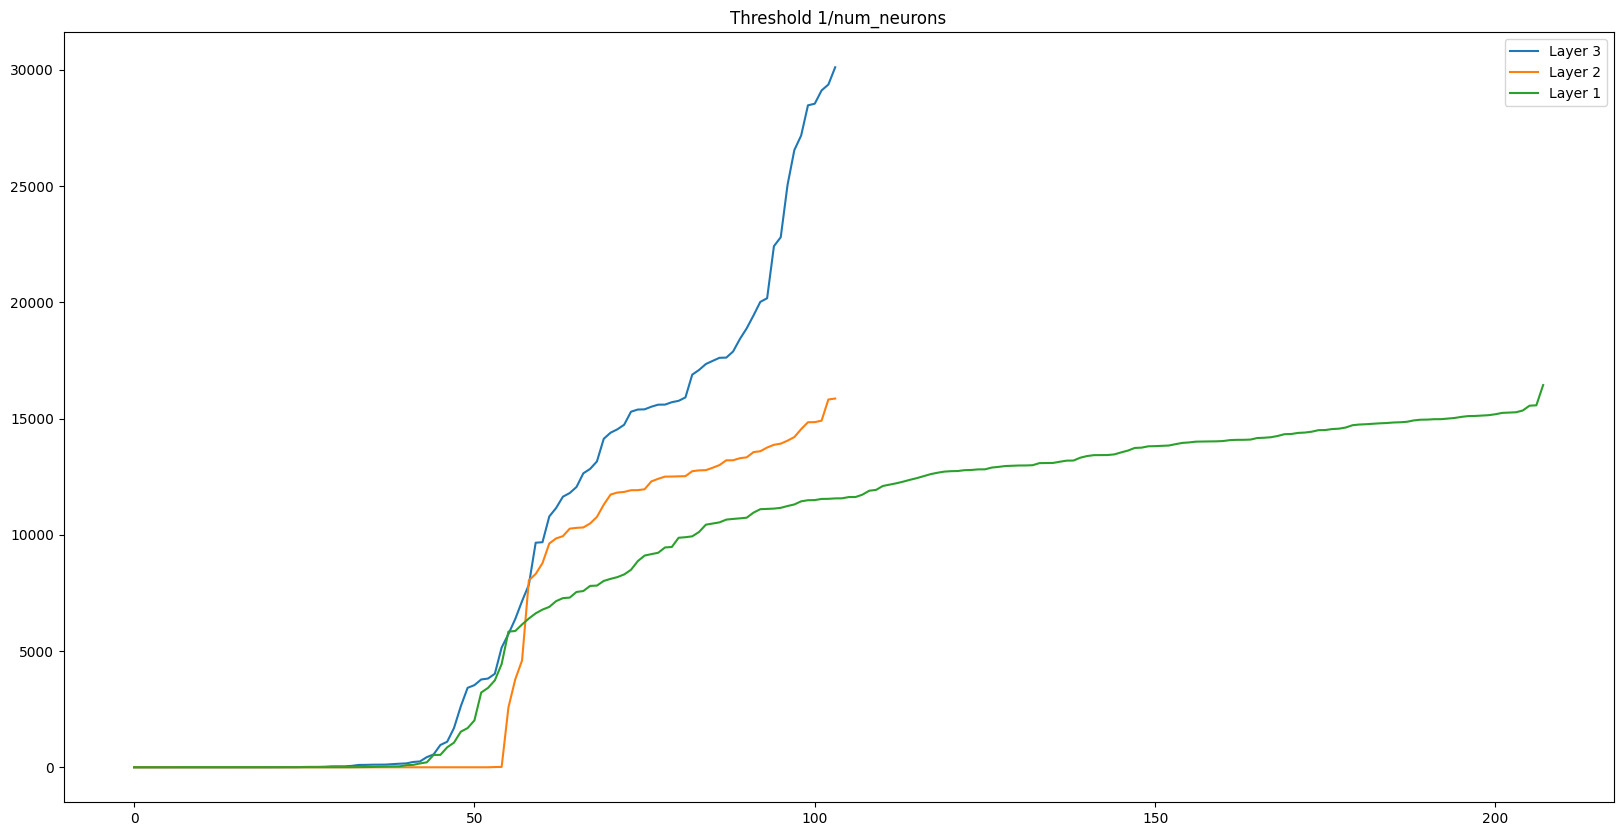

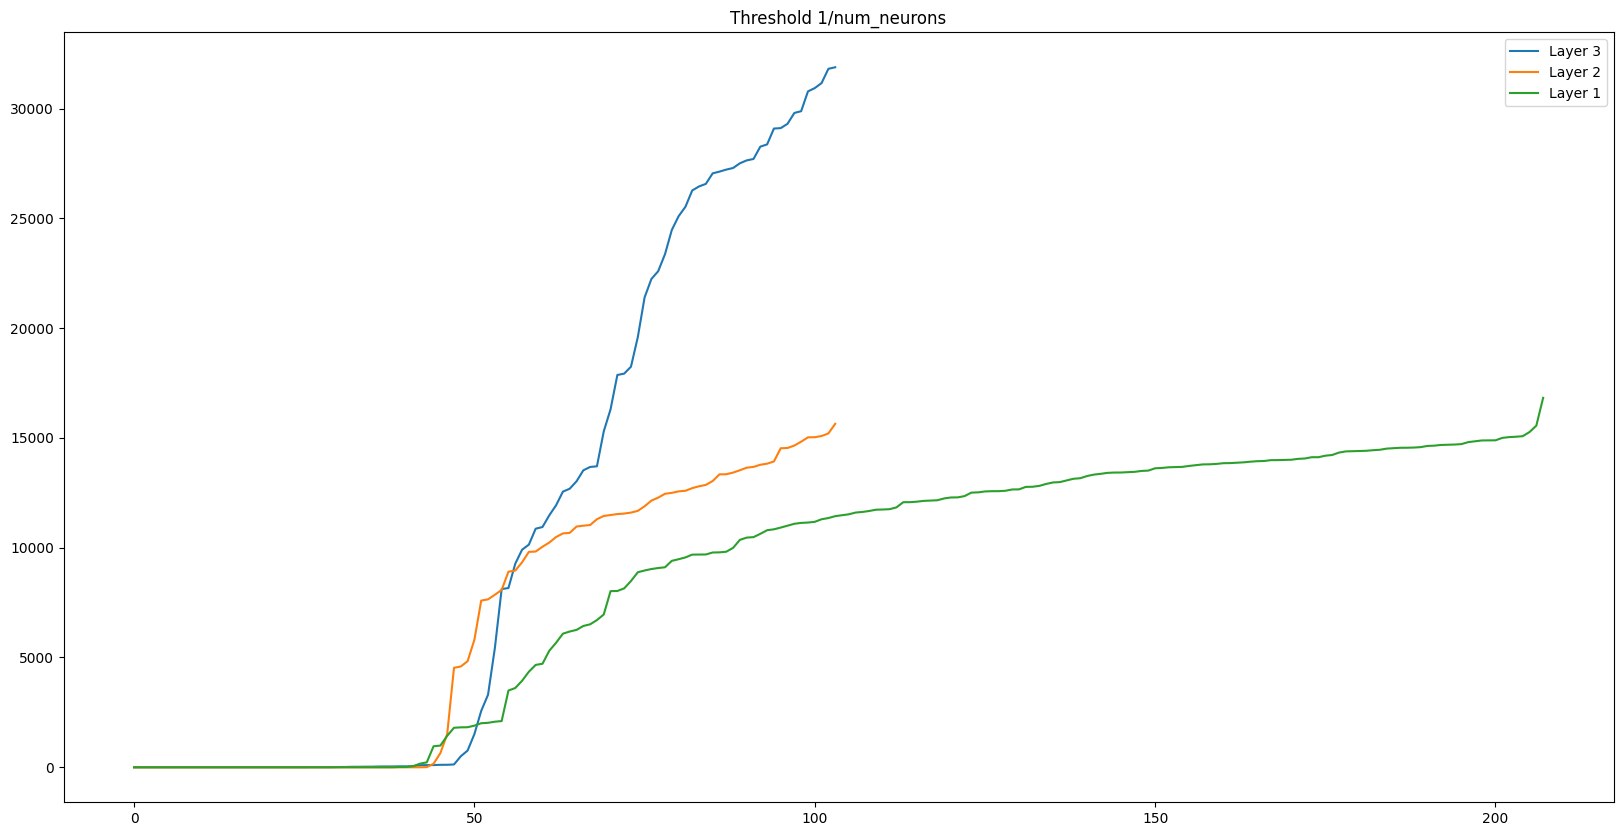

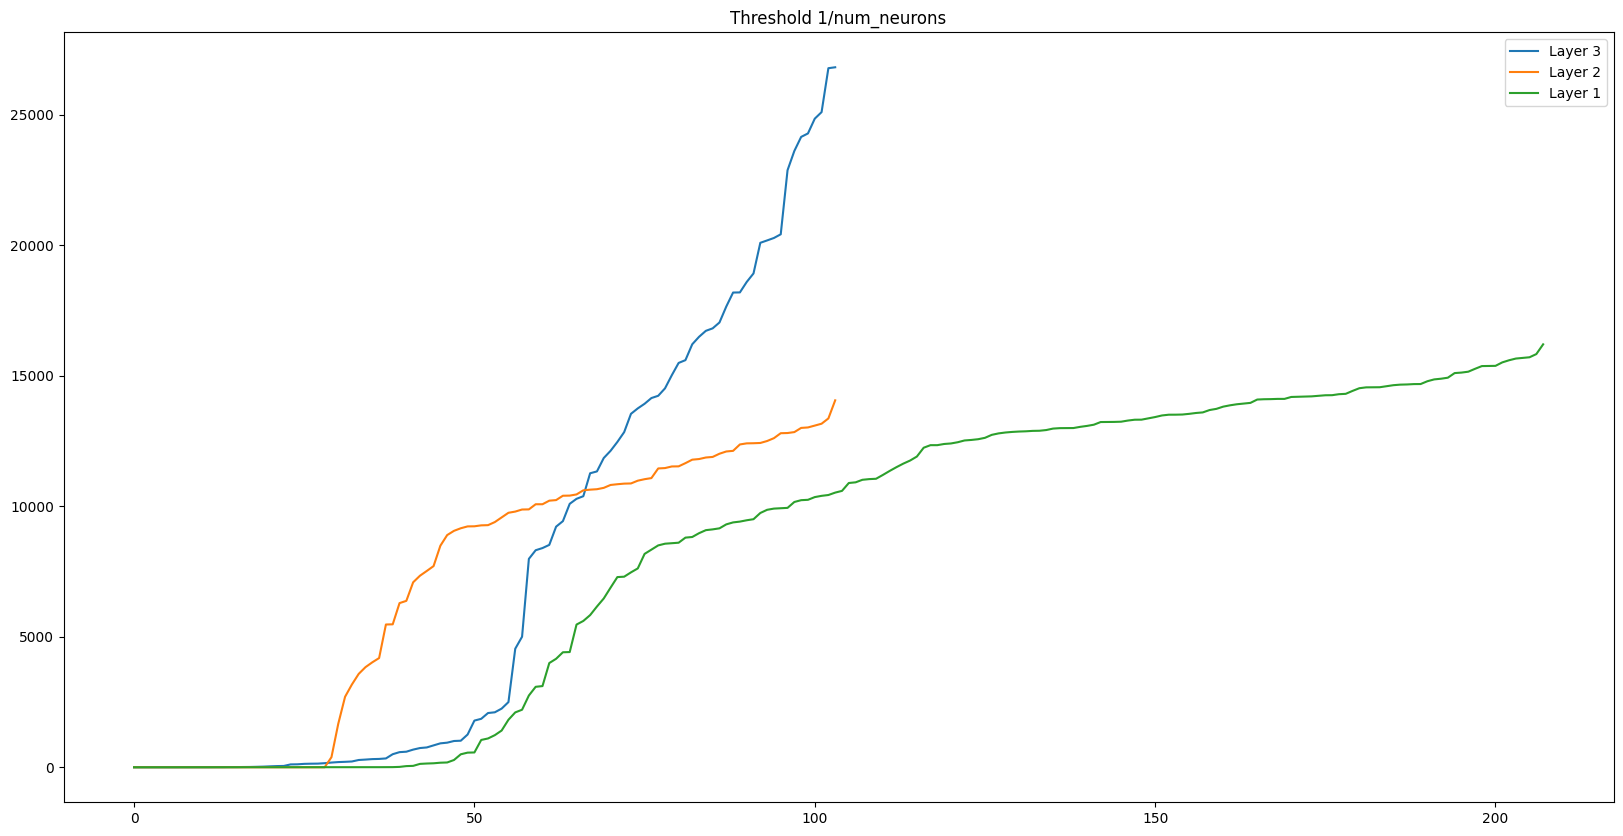

In [40]:
per_vid_num_pixels_with_meaningful_contrib = {}
per_vid_num_kernels_with_meaningful_contrib = {}

for dataset_name in dataset_names:
    for vidname in vidnames[dataset_name]:
        single_image_dataloader = dataloader_dict[dataset_name][vidname]
        ffn_model = ffn_models_dict[dataset_name][vidname]
        # categories_dict = categories_dicts[dataset_name][vidname]
        cfg = cfg_dict[dataset_name][vidname]

        inference_results = compute_inference_results(single_image_dataloader, ffn_model, cfg)
        per_vid_num_pixels_with_meaningful_contrib[vidname] = plot_pixels_per_neuron(inference_results, ffn_model)
        # per_vid_num_kernels_with_meaningful_contrib[vidname] = plot_neurons_per_pixel_heatmap(inference_results, ffn_model)

In [41]:
import pickle

save_dir = '../plotting_source_data/MLP/B-representation_is_distributed'
os.makedirs(save_dir, exist_ok=True)

with open(os.path.join(save_dir, f"per_vid_num_pixels_with_meaningful_contrib.pkl"), 'wb') as f:
    pickle.dump(per_vid_num_pixels_with_meaningful_contrib, f)
with open(os.path.join(save_dir, f"per_vid_num_kernels_with_meaningful_contrib.pkl"), 'wb') as f:
    pickle.dump(per_vid_num_kernels_with_meaningful_contrib, f)